In [1]:
import numpy as np 

import pandas as pd 

import matplotlib.pyplot as plt 
%matplotlib inline 
plt.style.use('seaborn') 

import datetime as datetime 
import time 

from sodapy import Socrata 

from IPython.display import Markdown, display 
def printmd(string): 
    display(Markdown(string)) 

In [2]:
client = Socrata("data.cityofchicago.org", "fjGOsCOhLa4EqoVFnLtjgT3mR") 
results = client.get("3i3m-jwuy", limit=50000) # 2018 dataset 
crimes = pd.DataFrame.from_records(results) 

# crimes.shape # (number of crimes, number of attributes) 

In [3]:
# only Illinois Tech crimes 
crimes = crimes.loc[crimes['y_coordinate'] >= "1881529"] 
crimes = crimes.loc[crimes['x_coordinate'] <= "1177934"] 
crimes = crimes.loc[crimes['x_coordinate'] >= "1175649"] 
crimes = crimes.loc[crimes['y_coordinate'] <= "1885312"] 

# delete some rows 
crimes.drop(['updated_on', 'location', 'community_area', 'ward', 'x_coordinate', 'y_coordinate'],  
                       inplace = True, axis=1) 
crimes.drop_duplicates(subset=['id', 'case_number'], inplace=True) 

# 2018-03-24T10:09:00 
crimes.date = pd.to_datetime(crimes.date, format='%Y-%m-%dT%H:%M:%S') 
crimes.index = pd.DatetimeIndex(crimes.date) 

In [4]:
printmd("## Out of the last 50,000 crimes in Chicago, <u>{}</u> took place in the Illinois Institute of Technology area. ".format(crimes.shape[0])) 
printmd("## These crimes range from {} to {}.".format(str(crimes.date.tail(1).dt.strftime('%m/%d/%Y'))[28:38], str(crimes.date.head(1).dt.strftime('%m/%d/%Y'))[28:38])) 

## Out of the last 50,000 crimes in Chicago, <u>88</u> took place in the Illinois Institute of Technology area. 

## These crimes range from 02/21/2018 to 05/04/2018.

<hr> 

### Types of Crimes 

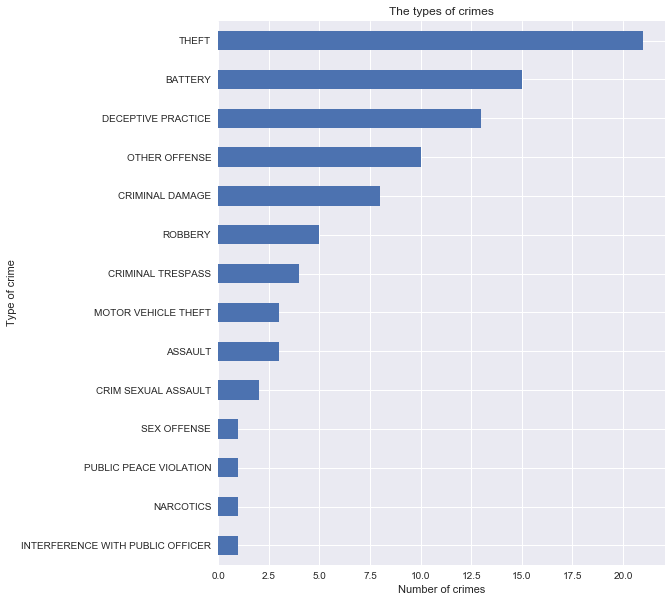

In [5]:
plt.figure(figsize=(8,10))
crimes.groupby([crimes['primary_type']]).size().sort_values(ascending=True).plot(kind='barh') 
plt.title('The types of crimes') 
plt.ylabel('Type of crime') 
plt.xlabel('Number of crimes') 
plt.show() 

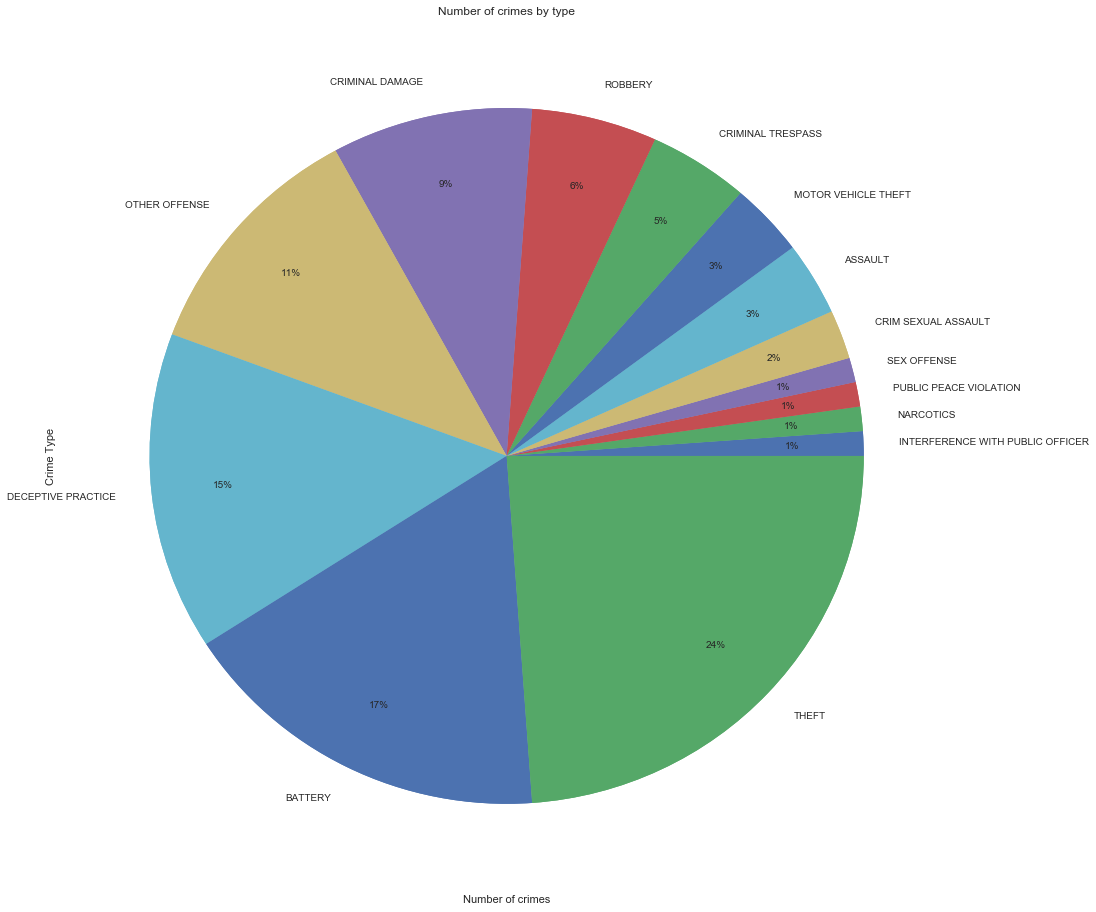

In [6]:
plt.figure(figsize=(16, 16)) 
crimes.groupby([crimes['primary_type']]).size().sort_values(ascending=True).plot(kind='pie') 
plt.title('Number of crimes by type') 
plt.ylabel('Crime Type') 
plt.xlabel('Number of crimes') 
plt.pie(crimes.groupby([crimes['primary_type']]).size().sort_values(ascending=True), autopct='%1.0f%%', pctdistance=.8, labeldistance=20)  
plt.show() 

### Number of Crimes in Time 

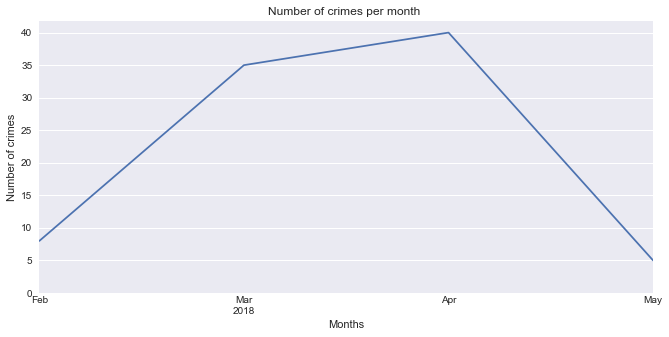

In [7]:
plt.figure(figsize=(11,5)) 
crimes.resample('M').size().plot(legend=False) 
plt.title('Number of crimes per month ') 
plt.xlabel('Months') 
plt.ylabel('Number of crimes') 
plt.ylim(ymin=0) 
plt.show() 

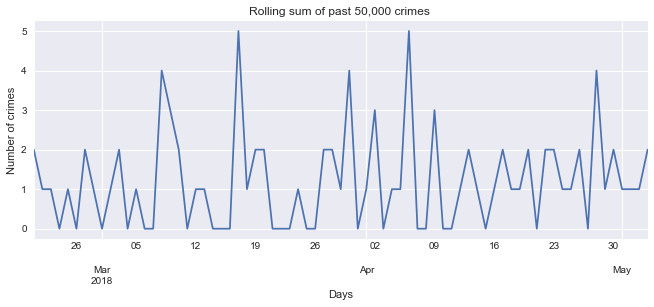

In [8]:
plt.figure(figsize=(11,4)) 
crimes.resample('D').size().rolling(1).sum().plot() 
plt.title('Rolling sum of past 50,000 crimes ') 
plt.ylabel('Number of crimes') 
plt.xlabel('Days') 
plt.show() 

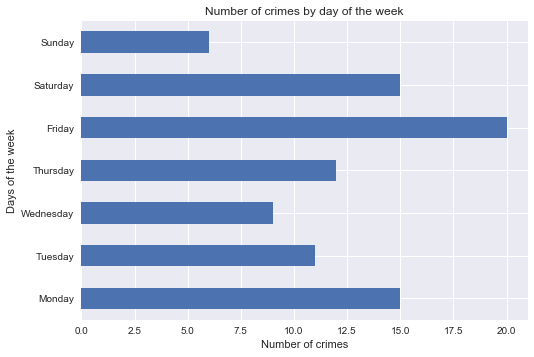

In [9]:
days = ['Monday','Tuesday','Wednesday',  'Thursday', 'Friday', 'Saturday', 'Sunday'] 
crimes.groupby([crimes.index.dayofweek]).size().plot(kind='barh') 
plt.ylabel('Days of the week') 
plt.yticks(np.arange(7), days) 
plt.xlabel('Number of crimes') 
plt.title('Number of crimes by day of the week') 
plt.show() 

### Time Frame of Crimes by Type 

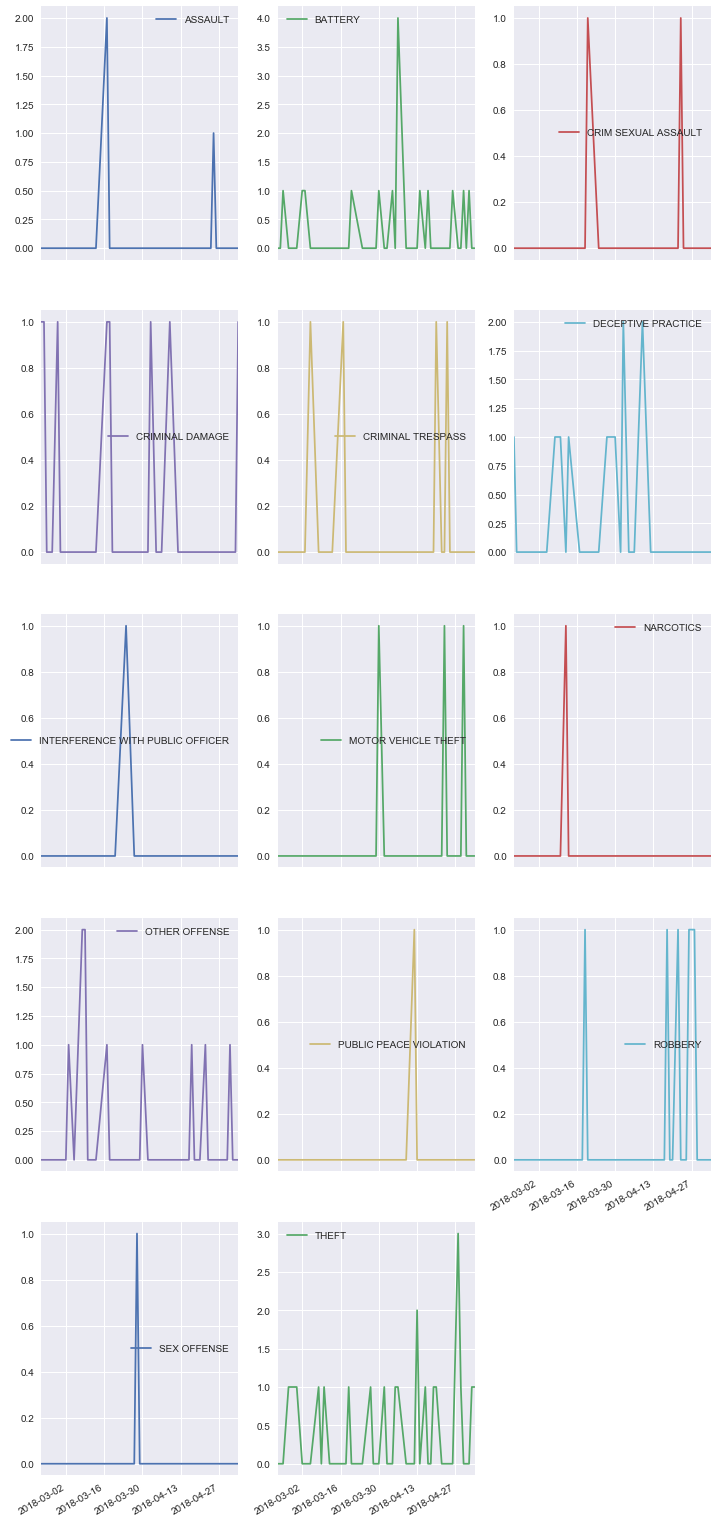

In [10]:
crimes_count_date = crimes.pivot_table('id', aggfunc=np.size, columns='primary_type', index=crimes.index.date, fill_value=0) 
crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index) 
plot = crimes_count_date.rolling(1).sum().plot(figsize=(12, 30), subplots=True, layout=(-1, 3), sharex=True, sharey=False, legend=True)  

### By Location 

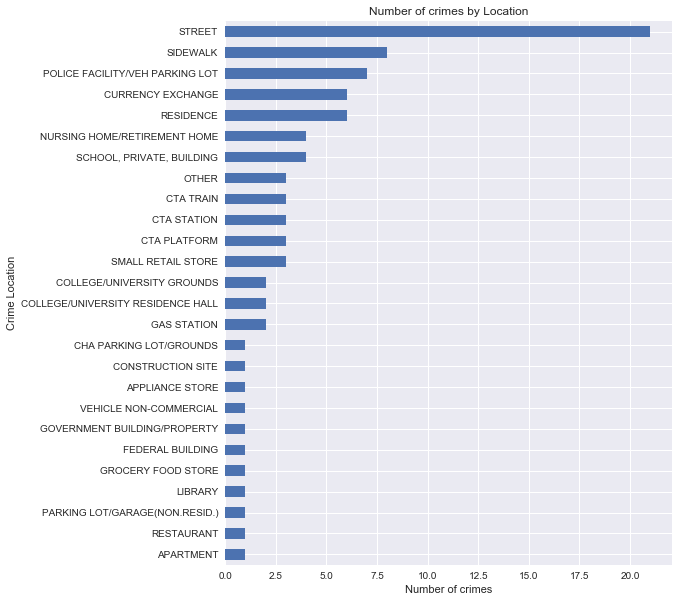

In [11]:
plt.figure(figsize=(8,10)) 
crimes.groupby([crimes['location_description']]).size().sort_values(ascending=True).plot(kind='barh') 
plt.title('Number of crimes by Location') 
plt.ylabel('Crime Location') 
plt.xlabel('Number of crimes') 
plt.show() 

In [12]:
from sklearn.cluster import AgglomerativeClustering as AC 

def scale_df(df,axis=0): 
    ''' 
    A utility function to scale numerical values (z-scale) to have a mean of zero 
    and a unit variance. 
    ''' 
    return (df - df.mean(axis=axis)) / df.std(axis=axis) 

def plot_hmap(df, ix=None, cmap='bwr'): 
    ''' 
    A function to plot heatmaps that show temporal patterns 
    ''' 
    if ix is None: 
        ix = np.arange(df.shape[0]) 
    cmap = plt.cm.YlOrRd 
    plt.imshow(df.iloc[ix,:], cmap=cmap) 
    plt.colorbar(fraction=0.03) 
    plt.yticks(np.arange(df.shape[0]), df.index[ix]) 
    plt.xticks(np.arange(len(set(df.columns))), df.columns) # now we can support smaller datasets with hours no fully filled 
    plt.grid(False) 
    plt.show() 
    
def scale_and_plot(df, ix = None): 
    ''' 
    A wrapper function to calculate the scaled values within each row of df and plot_hmap 
    ''' 
    df_marginal_scaled = scale_df(df.T).T 
    if ix is None: 
        ix = AC(4).fit(df_marginal_scaled).labels_.argsort() # a trick to make better heatmaps 
    cap = np.min([np.max(df_marginal_scaled.as_matrix()), np.abs(np.min(df_marginal_scaled.as_matrix()))]) 
    df_marginal_scaled = np.clip(df_marginal_scaled, -1*cap, cap) 
    plot_hmap(df_marginal_scaled, ix=ix) 

In [13]:
# Note that the code below is taken almost entirely from 
# https://www.kaggle.com/fahd09/eda-of-crime-in-chicago-2005-2016. 
# Maybe one day I will be this smart, but today is not that day. 

hour_by_location = crimes.pivot_table(values='id', index='location_description', columns=crimes.index.hour, aggfunc=np.size).fillna(0) 
hour_by_type = crimes.pivot_table(values='id', index='primary_type', columns=crimes.index.hour, aggfunc=np.size).fillna(0) 

# had to fix hour_by_week since default was very bugged 
hour_by_week = crimes.pivot_table(values='id', index=crimes.index.hour, columns=crimes.index.strftime("%A"), aggfunc=np.size).fillna(0) 
hour_by_week = hour_by_week[days].T # reorder columns according to the the order of days 

dayofweek_by_location = crimes.pivot_table(values='id', index='location_description', columns=crimes.index.dayofweek, aggfunc=np.size).fillna(0) 
dayofweek_by_type = crimes.pivot_table(values='id', index='primary_type', columns=crimes.index.dayofweek, aggfunc=np.size).fillna(0) 
location_by_type = crimes.pivot_table(values='id', index='location_description', columns='primary_type', aggfunc=np.size).fillna(0) 

### Type of Crime vs Hour [00 (12:00 am) - 23 (11:00 pm)] 

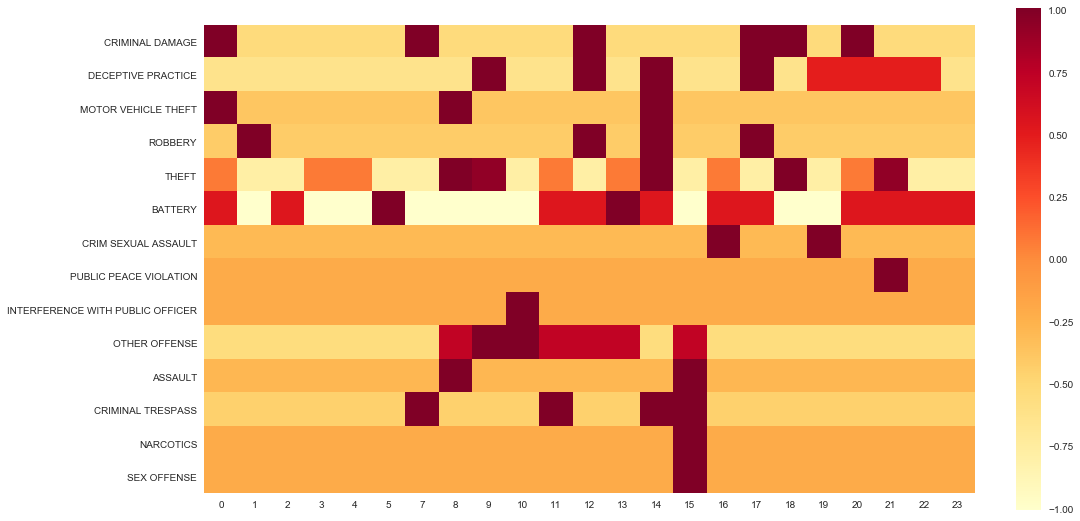

In [14]:
plt.figure(figsize=(15,12)) 
scale_and_plot(hour_by_type) 

### Location of Crime vs Hour [00 (12:00 am) - 23 (11:00 pm)] 

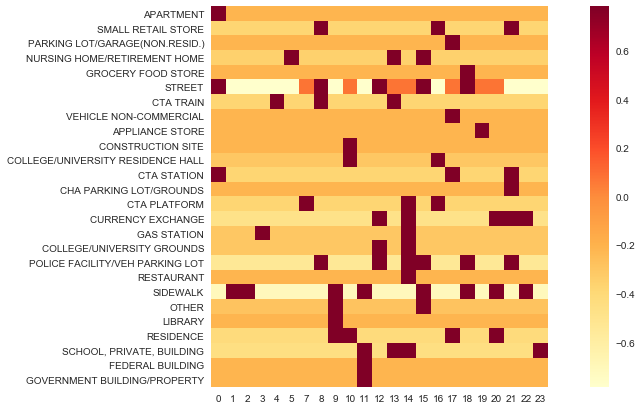

In [15]:
plt.figure(figsize=(15,7)) 
scale_and_plot(hour_by_location) 

### Type of Crime vs Day of Week [00 (12:00 am) - 23 (11:00 pm)] 

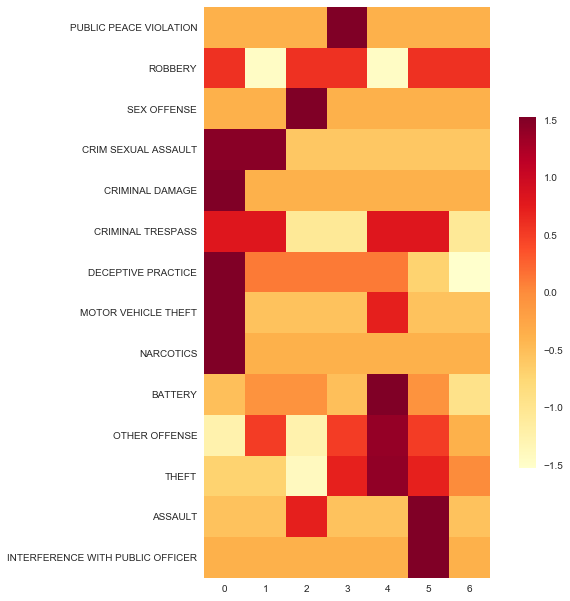

In [16]:
plt.figure(figsize=(10.5,10.5)) 
scale_and_plot(dayofweek_by_type) 

### Day of Week of Crime vs Hour [00 (12:00 am) - 23 (11:00 pm)] 

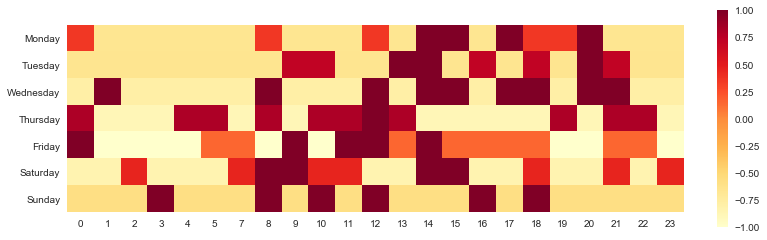

In [17]:
plt.figure(figsize=(12,4)) 
scale_and_plot(hour_by_week, ix=np.arange(7)) 